In [ ]:
!pip install -q langchain-community xmltodict pandas matplotlib seaborn wordcloud google-generativeai langchain-google-genai

import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

In [ ]:
class AdvancedPubMedResearcher:
    """Advanced PubMed research assistant with analysis capabilities"""

    def __init__(self, gemini_api_key=None):
        """Initialize the researcher with optional Gemini integration"""
        self.pubmed_tool = PubmedQueryRun()
        self.research_cache = {}

        if gemini_api_key:
            os.environ["GOOGLE_API_KEY"] = gemini_api_key
            self.llm = ChatGoogleGenerativeAI(
                model="gemini-1.5-flash",
                temperature=0,
                convert_system_message_to_human=True
            )
            self.agent = self._create_agent()
        else:
            self.llm = None
            self.agent = None

    def _create_agent(self):
        """Create LangChain agent with PubMed tool"""
        tools = [
            Tool(
                name="PubMed Search",
                func=self.pubmed_tool.invoke,
                description="Search PubMed for biomedical literature. Use specific terms."
            )
        ]

        return initialize_agent(
            tools,
            self.llm,
            agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
            verbose=True
        )

    def search_papers(self, query, max_results=5):
        """Search PubMed and parse results"""
        print(f"🔍 Searching PubMed for: '{query}'")

        try:
            results = self.pubmed_tool.invoke(query)
            papers = self._parse_pubmed_results(results)

            self.research_cache[query] = {
                'papers': papers,
                'timestamp': datetime.now(),
                'query': query
            }

            print(f"✅ Found {len(papers)} papers")
            return papers

        except Exception as e:
            print(f"❌ Error searching PubMed: {str(e)}")
            return []

    def _parse_pubmed_results(self, results):
        """Parse PubMed search results into structured data"""
        papers = []

        publications = results.split('\n\nPublished: ')[1:]

        for pub in publications:
            try:
                lines = pub.strip().split('\n')

                pub_date = lines[0] if lines else "Unknown"

                title_line = next((line for line in lines if line.startswith('Title: ')), '')
                title = title_line.replace('Title: ', '') if title_line else "Unknown Title"

                summary_start = None
                for i, line in enumerate(lines):
                    if 'Summary::' in line:
                        summary_start = i + 1
                        break

                summary = ""
                if summary_start:
                    summary = ' '.join(lines[summary_start:])

                papers.append({
                    'date': pub_date,
                    'title': title,
                    'summary': summary,
                    'word_count': len(summary.split()) if summary else 0
                })

            except Exception as e:
                print(f"⚠️ Error parsing paper: {str(e)}")
                continue

        return papers

    def analyze_research_trends(self, queries):
        """Analyze trends across multiple research topics"""
        print("📊 Analyzing research trends...")

        all_papers = []
        topic_counts = {}

        for query in queries:
            papers = self.search_papers(query, max_results=3)
            topic_counts[query] = len(papers)

            for paper in papers:
                paper['topic'] = query
                all_papers.append(paper)

        df = pd.DataFrame(all_papers)

        if df.empty:
            print("❌ No papers found for analysis")
            return None

        self._create_visualizations(df, topic_counts)

        return df

    def _create_visualizations(self, df, topic_counts):
        """Create research trend visualizations"""
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('PubMed Research Analysis Dashboard', fontsize=16, fontweight='bold')

        topics = list(topic_counts.keys())
        counts = list(topic_counts.values())

        axes[0,0].bar(range(len(topics)), counts, color='skyblue', alpha=0.7)
        axes[0,0].set_xlabel('Research Topics')
        axes[0,0].set_ylabel('Number of Papers')
        axes[0,0].set_title('Papers Found by Topic')
        axes[0,0].set_xticks(range(len(topics)))
        axes[0,0].set_xticklabels([t[:20]+'...' if len(t)>20 else t for t in topics], rotation=45, ha='right')

        if 'word_count' in df.columns and not df['word_count'].empty:
            axes[0,1].hist(df['word_count'], bins=10, color='lightcoral', alpha=0.7)
            axes[0,1].set_xlabel('Abstract Word Count')
            axes[0,1].set_ylabel('Frequency')
            axes[0,1].set_title('Distribution of Abstract Lengths')

        try:
            dates = pd.to_datetime(df['date'], errors='coerce')
            valid_dates = dates.dropna()
            if not valid_dates.empty:
                axes[1,0].hist(valid_dates, bins=10, color='lightgreen', alpha=0.7)
                axes[1,0].set_xlabel('Publication Date')
                axes[1,0].set_ylabel('Number of Papers')
                axes[1,0].set_title('Publication Timeline')
                plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=45)
        except:
            axes[1,0].text(0.5, 0.5, 'Date parsing unavailable', ha='center', va='center', transform=axes[1,0].transAxes)

        all_titles = ' '.join(df['title'].fillna('').astype(str))
        if all_titles.strip():
            clean_titles = re.sub(r'[^a-zA-Z\s]', '', all_titles.lower())

            try:
                wordcloud = WordCloud(width=400, height=300, background_color='white',
                                    max_words=50, colormap='viridis').generate(clean_titles)
                axes[1,1].imshow(wordcloud, interpolation='bilinear')
                axes[1,1].axis('off')
                axes[1,1].set_title('Common Words in Titles')
            except:
                axes[1,1].text(0.5, 0.5, 'Word cloud unavailable', ha='center', va='center', transform=axes[1,1].transAxes)

        plt.tight_layout()
        plt.show()

    def comparative_analysis(self, topic1, topic2):
        """Compare two research topics"""
        print(f"🔬 Comparing '{topic1}' vs '{topic2}'")

        papers1 = self.search_papers(topic1)
        papers2 = self.search_papers(topic2)

        avg_length1 = sum(p['word_count'] for p in papers1) / len(papers1) if papers1 else 0
        avg_length2 = sum(p['word_count'] for p in papers2) / len(papers2) if papers2 else 0

        print("\n📈 Comparison Results:")
        print(f"Topic 1 ({topic1}):")
        print(f"  - Papers found: {len(papers1)}")
        print(f"  - Avg abstract length: {avg_length1:.1f} words")

        print(f"\nTopic 2 ({topic2}):")
        print(f"  - Papers found: {len(papers2)}")
        print(f"  - Avg abstract length: {avg_length2:.1f} words")

        return papers1, papers2

    def intelligent_query(self, question):
        """Use AI agent to answer research questions (requires Gemini API)"""
        if not self.agent:
            print("❌ AI agent not available. Please provide Gemini API key.")
            print("💡 Get free API key at: https://makersuite.google.com/app/apikey")
            return None

        print(f"🤖 Processing intelligent query with Gemini: '{question}'")
        try:
            response = self.agent.run(question)
            return response
        except Exception as e:
            print(f"❌ Error with AI query: {str(e)}")
            return None

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
🚀 Advanced PubMed Research Assistant Tutorial

1️⃣ Basic PubMed Search
🔍 Searching PubMed for: 'CRISPR gene editing'
Too Many Requests, waiting for 0.20 seconds...
Too Many Requests, waiting for 0.40 seconds...
✅ Found 0 papers


2️⃣ Research Trends Analysis
📊 Analyzing research trends...
🔍 Searching PubMed for: 'machine learning healthcare'
Too Many Requests, waiting for 0.80 seconds...
✅ Found 0 papers
🔍 Searching PubMed for: 'CRISPR gene editing'
Too Many Requests, waiting for 1.60 seconds...
✅ Found 0 papers
🔍 Searching PubMed for: 'COVID-19 vaccine'
Too Many Requests, waiting for 3.20 seconds...
✅ Found 1 papers


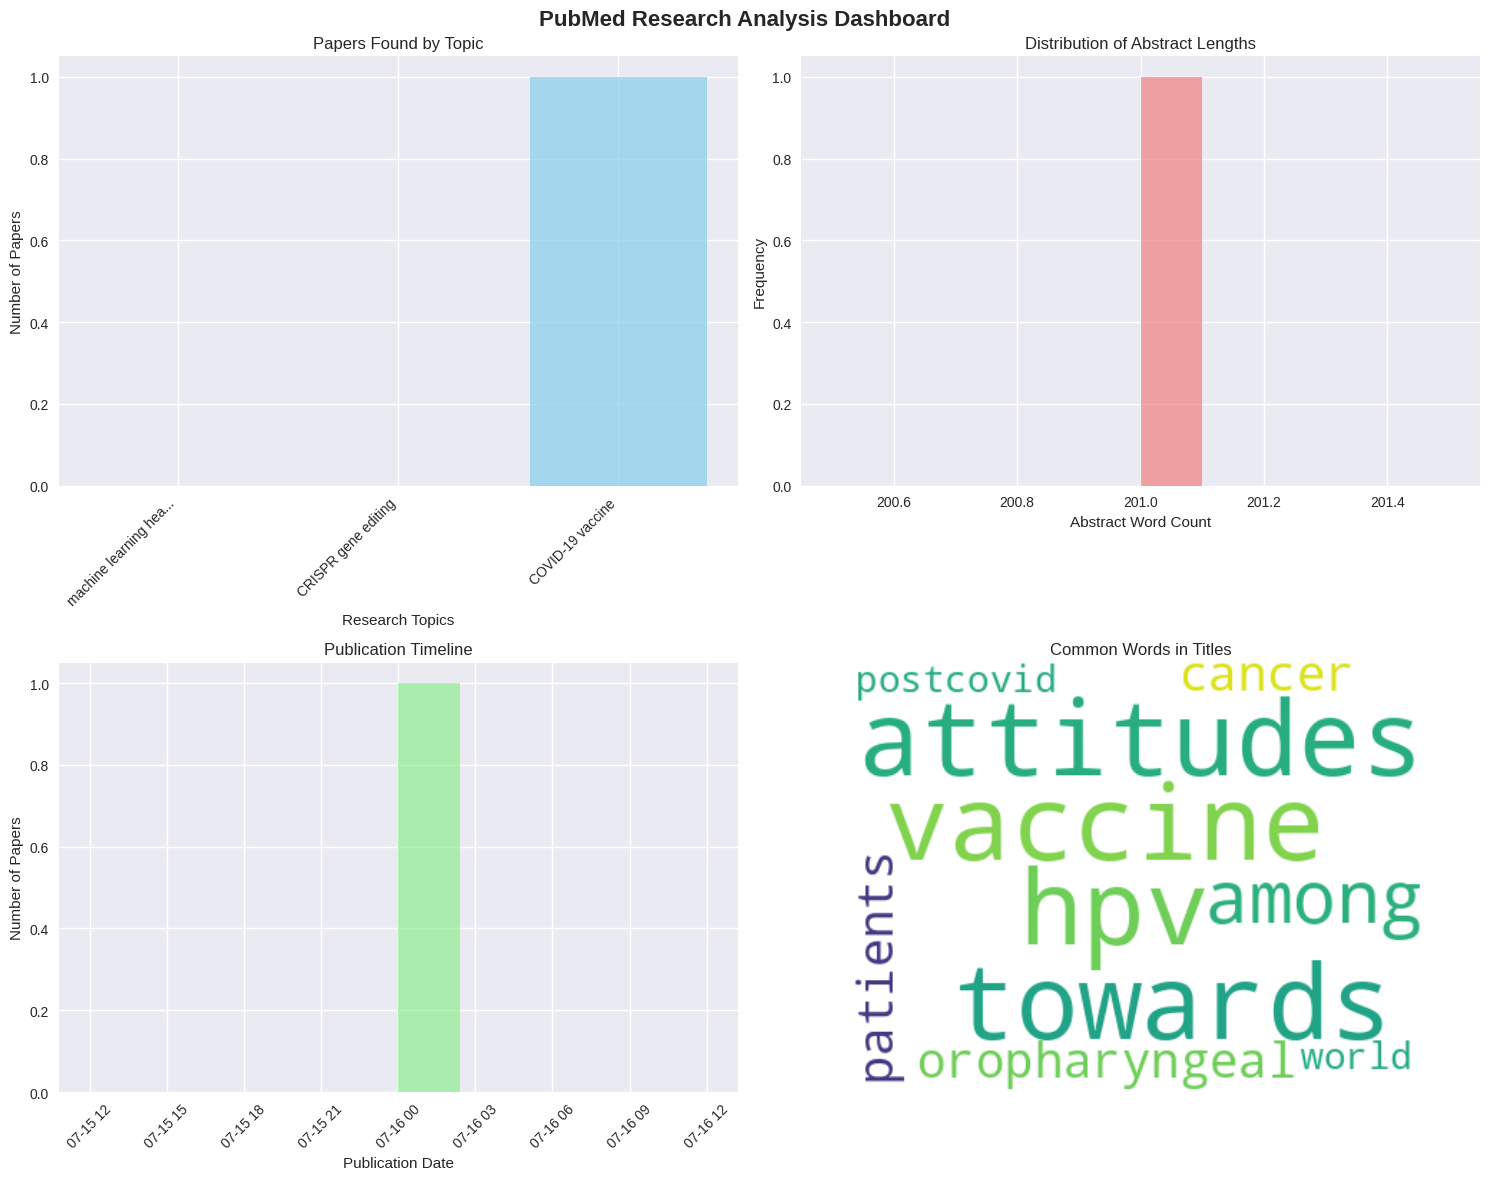


DataFrame shape: (1, 5)

Sample data:
              topic                                              title  \
0  COVID-19 vaccine  Attitudes Towards the HPV Vaccine Among Oropha...   

   word_count  
0         201  


3️⃣ Comparative Analysis
🔬 Comparing 'artificial intelligence diagnosis' vs 'traditional diagnostic methods'
🔍 Searching PubMed for: 'artificial intelligence diagnosis'
Too Many Requests, waiting for 6.40 seconds...
✅ Found 0 papers
🔍 Searching PubMed for: 'traditional diagnostic methods'
Too Many Requests, waiting for 12.80 seconds...
✅ Found 0 papers

📈 Comparison Results:
Topic 1 (artificial intelligence diagnosis):
  - Papers found: 0
  - Avg abstract length: 0.0 words

Topic 2 (traditional diagnostic methods):
  - Papers found: 0
  - Avg abstract length: 0.0 words


4️⃣ Advanced Features
Cache contents: ['CRISPR gene editing', 'machine learning healthcare', 'COVID-19 vaccine', 'artificial intelligence diagnosis', 'traditional diagnostic methods']
Latest cached qu

In [1]:
def main():
    """Main tutorial demonstration"""
    print("🚀 Advanced PubMed Research Assistant Tutorial")
    print("=" * 50)

    # Initialize researcher
    # Uncomment next line and add your free Gemini API key for AI features
    # Get your free API key at: https://makersuite.google.com/app/apikey
    # researcher = AdvancedPubMedResearcher(gemini_api_key="your-gemini-api-key")
    researcher = AdvancedPubMedResearcher()

    print("\n1️⃣ Basic PubMed Search")
    papers = researcher.search_papers("CRISPR gene editing", max_results=3)

    if papers:
        print(f"\nFirst paper preview:")
        print(f"Title: {papers[0]['title']}")
        print(f"Date: {papers[0]['date']}")
        print(f"Summary preview: {papers[0]['summary'][:200]}...")

    print("\n\n2️⃣ Research Trends Analysis")
    research_topics = [
        "machine learning healthcare",
        "CRISPR gene editing",
        "COVID-19 vaccine"
    ]

    df = researcher.analyze_research_trends(research_topics)

    if df is not None:
        print(f"\nDataFrame shape: {df.shape}")
        print("\nSample data:")
        print(df[['topic', 'title', 'word_count']].head())

    print("\n\n3️⃣ Comparative Analysis")
    papers1, papers2 = researcher.comparative_analysis(
        "artificial intelligence diagnosis",
        "traditional diagnostic methods"
    )

    print("\n\n4️⃣ Advanced Features")
    print("Cache contents:", list(researcher.research_cache.keys()))

    if researcher.research_cache:
        latest_query = list(researcher.research_cache.keys())[-1]
        cached_data = researcher.research_cache[latest_query]
        print(f"Latest cached query: '{latest_query}'")
        print(f"Cached papers count: {len(cached_data['papers'])}")

    print("\n✅ Tutorial complete!")
    print("\nNext steps:")
    print("- Add your FREE Gemini API key for AI-powered analysis")
    print("  Get it at: https://makersuite.google.com/app/apikey")
    print("- Customize queries for your research domain")
    print("- Export results to CSV with: df.to_csv('research_results.csv')")

    print("\n🎁 Bonus: To test AI features, run:")
    print("researcher = AdvancedPubMedResearcher(gemini_api_key='your-key')")
    print("response = researcher.intelligent_query('What are the latest breakthrough in cancer treatment?')")
    print("print(response)")

if __name__ == "__main__":
    main()